In [2]:
import sys
print(sys.version)


3.12.7 | packaged by conda-forge | (main, Oct  4 2024, 15:47:54) [MSC v.1941 64 bit (AMD64)]


In [3]:
import numpy as np

In [4]:
import pandas as pd

In [5]:
import seaborn as sns

In [6]:
import sklearn as sk

In [7]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
import re,string,unicodedata

In [8]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split

In [9]:
import nltk
from nltk.corpus import stopwords

In [10]:
from string import punctuation

In [11]:
x_train = pd.read_csv("x_train.csv")
y_train = pd.read_csv("y_train.csv")
x_test = pd.read_csv("x_test.csv")
y_test = pd.read_csv("y_test.csv")
x_train = x_train.to_numpy(dtype=np.float16)
y_train = y_train.to_numpy(dtype=np.float16)
x_test = x_test.to_numpy(dtype=np.float16)
y_test = y_test.to_numpy(dtype=np.float16)

In [12]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

In [13]:
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

x_train = torch.tensor(x_train, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)

#### ilk yol

Epoch [10/100], Loss: 18.6934
Epoch [20/100], Loss: 18.0545
Epoch [30/100], Loss: 17.6565
Epoch [40/100], Loss: 17.3836
Epoch [50/100], Loss: 17.1344
Epoch [60/100], Loss: 16.9471
Epoch [70/100], Loss: 16.8112
Epoch [80/100], Loss: 16.7175
Epoch [90/100], Loss: 16.6442
Epoch [100/100], Loss: 16.5913
en iyi kontrol noktaları:
[tensor([-0.0698, -0.0113,  0.0441,  ..., -0.0196,  0.1355,  0.0879],
       device='cuda:0'), tensor([ 0.5532, -0.1031, -0.5119,  ...,  0.9645, -0.3361, -0.4032],
       device='cuda:0'), tensor([ 0.2362, -0.1066, -0.6185,  ..., -0.5189, -0.0906, -1.0440],
       device='cuda:0'), tensor([ 0.8558,  1.7572, -0.1635,  ..., -0.9948,  1.1491, -0.4541],
       device='cuda:0'), tensor([ 0.0597, -0.0779,  0.0774,  ..., -0.3310,  0.0810,  0.0358],
       device='cuda:0')]
ilk kontrol noktaları:
[Parameter containing:
tensor([ 0.7936, -0.1393, -0.4009,  ...,  0.9312, -0.3481, -0.4481],
       device='cuda:0', requires_grad=True), Parameter containing:
tensor([ 0.3981, -0.

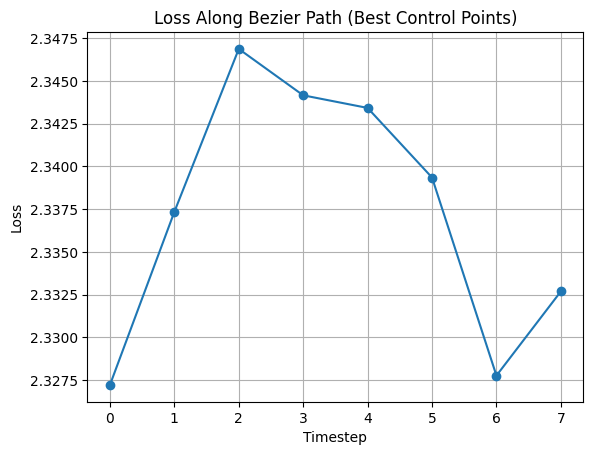

In [67]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import math
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset


class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, hidden_size1, output_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size1)
        self.relu = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size1, output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.softmax(x)
        return x


def train_model_with_shuffling(model, X, y, optimizer, criterion, epochs=500, batch_size=2048):
    dataset = TensorDataset(X, y)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    for epoch in range(epochs):
        for batch_X, batch_y in dataloader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, torch.argmax(batch_y, dim=1))
            loss.backward()
            optimizer.step()

    return model


def get_model_params(model):
    return torch.cat([p.data.flatten() for p in model.parameters()])


def manual_model_forward(X, params, layer_sizes):
    W1 = params[:layer_sizes[0] * layer_sizes[1]].reshape(layer_sizes[1], layer_sizes[0])
    b1 = params[layer_sizes[0] * layer_sizes[1]:layer_sizes[0] * layer_sizes[1] + layer_sizes[1]]
    
    W2_start = layer_sizes[0] * layer_sizes[1] + layer_sizes[1]
    W2 = params[W2_start:W2_start + layer_sizes[1] * layer_sizes[2]].reshape(layer_sizes[2], layer_sizes[1])
    b2_start = W2_start + layer_sizes[1] * layer_sizes[2]
    b2 = params[b2_start:b2_start + layer_sizes[2]]
    
    W3_start = b2_start + layer_sizes[2]
    W3 = params[W3_start:W3_start + layer_sizes[2] * layer_sizes[3]].reshape(layer_sizes[3], layer_sizes[2])
    b3_start = W3_start + layer_sizes[2] * layer_sizes[3]
    b3 = params[b3_start:]


    W1 = W1.to(device)
    W2 = W2.to(device)
    W3 = W3.to(device)
    b1 = b1.to(device)
    b2 = b2.to(device)
    b3 = b3.to(device)

    
    x = torch.relu(X @ W1.T + b1)
    x = torch.relu(x @ W2.T + b2)
    x = torch.softmax(x @ W3.T + b3, dim=1)
    return x


def compute_bezier_point(t, control_points):
    n = len(control_points) - 1
    point = torch.zeros_like(control_points[0])

    for i in range(n + 1):
        coef = torch.tensor(math.comb(n, i) * (t ** i) * ((1 - t) ** (n - i)), device=control_points[0].device)
        point += coef * control_points[i]

    return point


def optimize_path(model1_params, model2_params, criterion, X, y, layer_sizes, num_steps=8, num_iterations=100):
    param_size = len(model1_params)

    control_points = [
        model1_params.clone().detach().to(device).requires_grad_(False),
        torch.randn(param_size, device=device, requires_grad=True),
        torch.randn(param_size, device=device, requires_grad=True),
        torch.randn(param_size, device=device, requires_grad=True),
        model2_params.clone().detach().to(device).requires_grad_(False)
    ]

    middle_points111 = [torch.nn.Parameter(p.clone()) for p in control_points[1:-1]]
    optimizer = optim.Adam(control_points[1:-1], lr=0.01)
    best_loss = float('inf')
    best_control_points = None

    for iteration in range(num_iterations):
        total_path_loss = 0

        for step in range(num_steps):
            t = step / (num_steps - 1)
            params = compute_bezier_point(t, control_points)
            outputs = manual_model_forward(X, params, layer_sizes)
            loss = criterion(outputs, torch.argmax(y, dim=1))
            total_path_loss += loss

        optimizer.zero_grad()
        total_path_loss.backward()
        optimizer.step()

        # Ara sıra kaybı yazdır
        if (iteration + 1) % 10 == 0:
            print(f"Epoch [{iteration+1}/{num_iterations}], Loss: {total_path_loss.item():.4f}")

        if total_path_loss.item() < best_loss:
            best_loss = total_path_loss.item()
            best_control_points = [p.clone().detach() for p in control_points]

    return best_control_points, best_loss, middle_points111



def evaluate_best_path_loss(best_control_points, X, y, criterion, layer_sizes, num_steps=8):
    losses = []
    acc = []
    for step in range(num_steps):
        t = step / (num_steps - 1)
        params = compute_bezier_point(t, best_control_points)
      
        if t == (3/7):
            point1params = params  

        # Manuel yeniden kurma için layer_sizes 
        #layer_sizes = [input_size, hidden_size, hidden_size1, output_size]    (girdi olarak verdim)
        
        # Manuel olarak ileri yayılım
        outputs = manual_model_forward(X, params, layer_sizes)
        predicted_classes = torch.argmax(outputs, dim=1)
        true_classes = torch.argmax(y, dim=1)
        loss = criterion(outputs, torch.argmax(y, dim=1))
        accuracy = (predicted_classes == true_classes).sum().item() / true_classes.size(0)
        acc.append(accuracy)
        losses.append(loss.item())
    return losses, point1params, acc


def find_path_between_minima(x_train, y_train, x_test, y_test):
    global device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    if not isinstance(x_train, torch.Tensor):
        x_train = torch.FloatTensor(x_train).to(device)
    if not isinstance(y_train, torch.Tensor):
        y_train = torch.FloatTensor(y_train).to(device)
    if not isinstance(x_test, torch.Tensor):
        x_test = torch.FloatTensor(x_test).to(device)
    if not isinstance(y_test, torch.Tensor):
        y_test = torch.FloatTensor(y_test).to(device)


    x_train = x_train.to(device)
    y_train = y_train.to(device)
    x_test = x_test.to(device)
    y_test = y_test.to(device)
    

    input_size = 1024
    hidden_size = 512
    hidden_size1 = 256
    output_size = 16
    layer_sizes = [input_size, hidden_size, hidden_size1, output_size]

    model1 = SimpleNN(input_size, hidden_size, hidden_size1, output_size).to(device)
    model2 = SimpleNN(input_size, hidden_size, hidden_size1, output_size).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer1 = optim.Adam(model1.parameters(), lr=0.01)
    optimizer2 = optim.Adam(model2.parameters(), lr=0.01)

    model1 = train_model_with_shuffling(model1, x_train, y_train, optimizer1, criterion)
    model2 = train_model_with_shuffling(model2, x_train, y_train, optimizer2, criterion)

    model1_params = get_model_params(model1)
    model2_params = get_model_params(model2)

    best_control_points, best_loss, middle_points111 = optimize_path(
        model1_params,
        model2_params,
        criterion,
        x_train,
        y_train,
        layer_sizes
    )

    losses_bez, point1params, acc = evaluate_best_path_loss(best_control_points, x_test, y_test, criterion, layer_sizes)

    return best_control_points, best_loss, losses_bez, middle_points111, model1_params, model2_params, point1params, acc


if __name__ == "__main__":
    best_control_points, best_loss, losses_bez1, middle_points111, model1_params, model2_params, point1params, acc1 = find_path_between_minima(x_train, y_train, x_test, y_test)

    print("en iyi kontrol noktaları:")
    print(best_control_points)
    print("ilk kontrol noktaları:")
    print(middle_points111)
    
    plt.plot(range(len(losses_bez1)), losses_bez1, marker='o')
    plt.title("Loss Along Bezier Path (Best Control Points)")
    plt.xlabel("Timestep")
    plt.ylabel("Loss")
    plt.grid()
    plt.show()


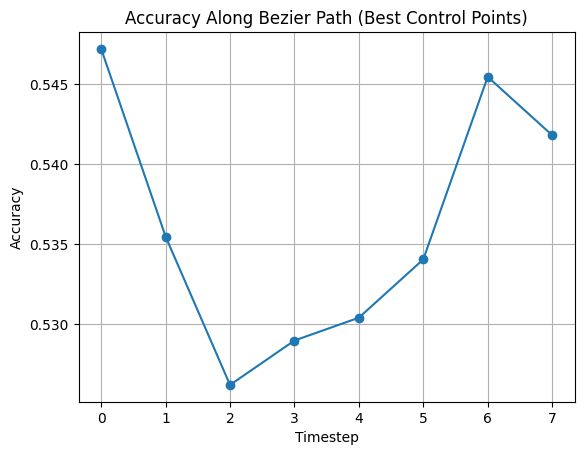

In [73]:
plt.plot(range(len(acc1)), acc1, marker='o')
plt.title("Accuracy Along Bezier Path (Best Control Points)")
plt.xlabel("Timestep")
plt.ylabel("Accuracy")
plt.grid()
plt.show()

In [50]:
print(model1_params.device)
print(model2_params.device)
print(point1params.device)

cuda:0
cuda:0
cuda:0


In [83]:
torch.save(model1_params, "model1_params.pt")
torch.save(model2_params, "model2_params.pt")
torch.save(point1params, "point1params.pt")

In [90]:
loaded_model1_params = torch.load("model1_params.pt")
loaded_model2_params = torch.load("model2_params.pt")
loaded_point1params = torch.load("point1params.pt")
loaded_model1_params

C:\Users\afyil\AppData\Local\Temp\ipykernel_21832\3271008957.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model1_params = torch.load("model1_params.pt")
C:\Use

tensor([ 0.4410,  0.0976, -0.1180,  ..., -0.2340, -0.2501,  0.1578],
       device='cuda:0')

In [92]:
model1_params

tensor([ 0.4410,  0.0976, -0.1180,  ..., -0.2340, -0.2501,  0.1578],
       device='cuda:0')

In [58]:
print(loaded_model2_params.device)

cuda:0


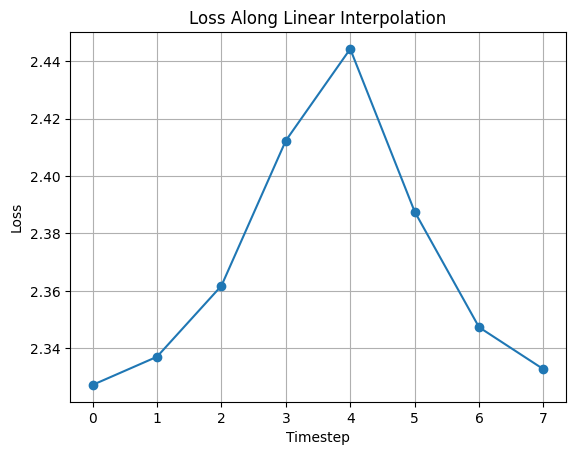

In [75]:
import torch
import numpy as np
import matplotlib.pyplot as plt



x_test = x_test.to(device)
y_test = y_test.to(device)

layer_sizes = [1024, 512, 256, 16]



# Doğrusal interpolasyon fonksiyonu
def linear_interpolation(t, w1, w2):
    return (1 - t) * w1 + t * w2




def evaluate_linear_interpolation_loss(w1, w2, X, y, criterion, layer_sizes, num_steps=8):
    losses = []
    acc = []
    for step in range(num_steps):
        t = step / (num_steps - 1)
        params = linear_interpolation(t, w1, w2)

        # Manuel yeniden kurma için layer_sizes
        #layer_sizes = [input_size, hidden_size, hidden_size1, output_size]    (girdi olarak verdim)
        
        # Manuel olarak ileri yayılım
        outputs = manual_model_forward(X, params, layer_sizes)
        predicted_classes = torch.argmax(outputs, dim=1)
        true_classes = torch.argmax(y, dim=1)
        loss = criterion(outputs, torch.argmax(y, dim=1))
        accuracy = (predicted_classes == true_classes).sum().item() / true_classes.size(0)
        acc.append(accuracy)
        losses.append(loss.item())
    return losses, acc




if __name__ == "__main__":


    x_train = torch.FloatTensor(x_train)
    y_train = torch.FloatTensor(y_train)


    criterion = nn.CrossEntropyLoss()

    losses_lin1, acc_lin1 = evaluate_linear_interpolation_loss(model1_params, model2_params, x_test, y_test, criterion, layer_sizes)
    # Loss grafiği
    plt.plot(range(len(losses_lin1)), losses_lin1, marker='o')
    plt.title("Loss Along Linear Interpolation")
    plt.xlabel("Timestep")
    plt.ylabel("Loss")
    plt.grid()
    plt.show()


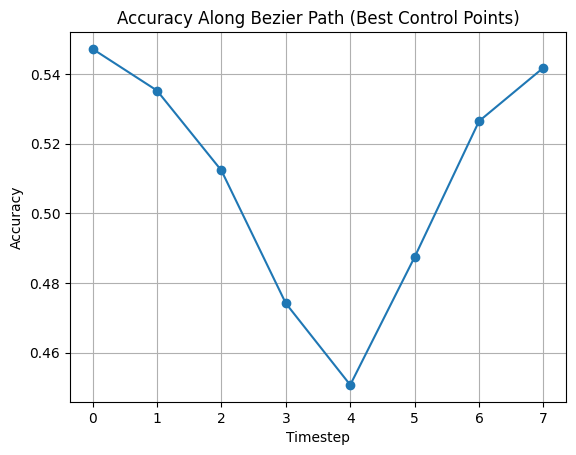

In [77]:
plt.plot(range(len(acc_lin1)), acc_lin1, marker='o')
plt.title("Accuracy Along Bezier Path (Best Control Points)")
plt.xlabel("Timestep")
plt.ylabel("Accuracy")
plt.grid()
plt.show()

In [46]:
x_test.device

device(type='cuda', index=0)

In [44]:
model1_params.device

device(type='cuda', index=0)

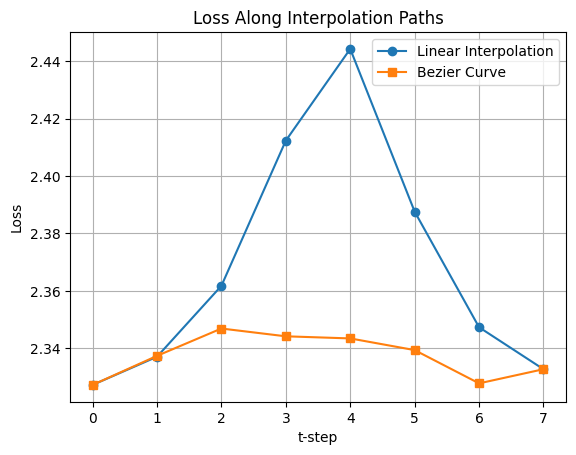

In [79]:
plt.plot(range(len(losses_lin1)), losses_lin1, marker='o', label='Linear Interpolation')
plt.plot(range(len(losses_bez1)), losses_bez1, marker='s', label='Bezier Curve')
plt.title("Loss Along Interpolation Paths")
plt.xlabel("t-step")
plt.ylabel("Loss")
plt.grid()
plt.legend()
plt.show()

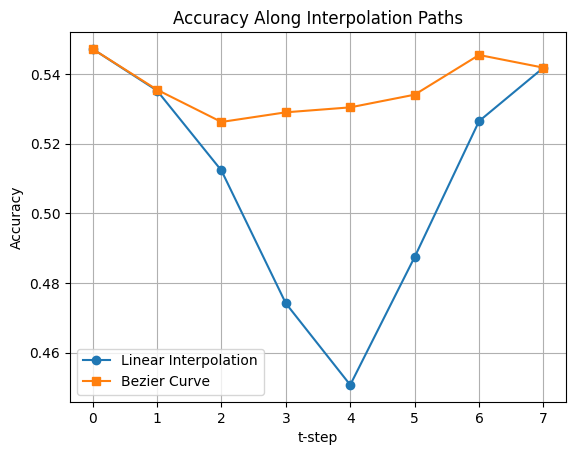

In [81]:
plt.plot(range(len(acc_lin1)), acc_lin1, marker='o', label='Linear Interpolation')
plt.plot(range(len(acc1)), acc1, marker='s', label='Bezier Curve')
plt.title("Accuracy Along Interpolation Paths")
plt.xlabel("t-step")
plt.ylabel("Accuracy")
plt.grid()
plt.legend()
plt.show()

#### ikinci yol

Epoch [10/100], Loss: 18.6910
Epoch [20/100], Loss: 17.9473
Epoch [30/100], Loss: 17.5393
Epoch [40/100], Loss: 17.2298
Epoch [50/100], Loss: 17.0583
Epoch [60/100], Loss: 16.9459
Epoch [70/100], Loss: 16.8365
Epoch [80/100], Loss: 16.7226
Epoch [90/100], Loss: 16.6346
Epoch [100/100], Loss: 16.5716
en iyi kontrol noktaları:
[tensor([ 0.0597, -0.0779,  0.0774,  ..., -0.3310,  0.0810,  0.0358],
       device='cuda:0'), tensor([-0.8914,  1.2502,  1.5222,  ..., -1.0460,  0.1970,  0.7403],
       device='cuda:0'), tensor([ 0.1603, -0.6904,  0.9470,  ...,  0.9926,  0.5518,  0.4622],
       device='cuda:0'), tensor([-0.0565, -0.1789, -0.0381,  ...,  0.1505, -0.6858,  1.0048],
       device='cuda:0'), tensor([ 0.0253, -0.0568,  0.0476,  ..., -0.0166,  0.1292, -0.0517],
       device='cuda:0')]
ilk kontrol noktaları:
[Parameter containing:
tensor([-0.9878,  1.1753,  1.6714,  ..., -1.1153, -0.0764,  0.6396],
       device='cuda:0', requires_grad=True), Parameter containing:
tensor([ 0.0696, -0.

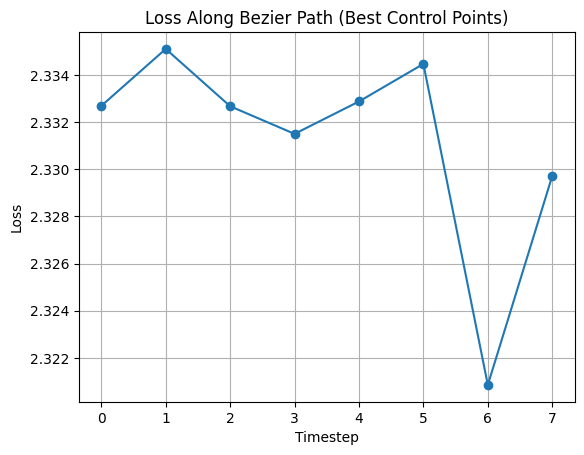

In [85]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import math
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset


class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, hidden_size1, output_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size1)
        self.relu = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size1, output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.softmax(x)
        return x


def train_model_with_shuffling(model, X, y, optimizer, criterion, epochs=500, batch_size=2048):
    dataset = TensorDataset(X, y)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    for epoch in range(epochs):
        for batch_X, batch_y in dataloader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, torch.argmax(batch_y, dim=1))
            loss.backward()
            optimizer.step()

    return model


def get_model_params(model):
    return torch.cat([p.data.flatten() for p in model.parameters()])


def manual_model_forward(X, params, layer_sizes):
    W1 = params[:layer_sizes[0] * layer_sizes[1]].reshape(layer_sizes[1], layer_sizes[0])
    b1 = params[layer_sizes[0] * layer_sizes[1]:layer_sizes[0] * layer_sizes[1] + layer_sizes[1]]
    
    W2_start = layer_sizes[0] * layer_sizes[1] + layer_sizes[1]
    W2 = params[W2_start:W2_start + layer_sizes[1] * layer_sizes[2]].reshape(layer_sizes[2], layer_sizes[1])
    b2_start = W2_start + layer_sizes[1] * layer_sizes[2]
    b2 = params[b2_start:b2_start + layer_sizes[2]]
    
    W3_start = b2_start + layer_sizes[2]
    W3 = params[W3_start:W3_start + layer_sizes[2] * layer_sizes[3]].reshape(layer_sizes[3], layer_sizes[2])
    b3_start = W3_start + layer_sizes[2] * layer_sizes[3]
    b3 = params[b3_start:]


    W1 = W1.to(device)
    W2 = W2.to(device)
    W3 = W3.to(device)
    b1 = b1.to(device)
    b2 = b2.to(device)
    b3 = b3.to(device)

    
    x = torch.relu(X @ W1.T + b1)
    x = torch.relu(x @ W2.T + b2)
    x = torch.softmax(x @ W3.T + b3, dim=1)
    return x


def compute_bezier_point(t, control_points):
    n = len(control_points) - 1
    point = torch.zeros_like(control_points[0])

    for i in range(n + 1):
        coef = torch.tensor(math.comb(n, i) * (t ** i) * ((1 - t) ** (n - i)), device=control_points[0].device)
        point += coef * control_points[i]

    return point


def optimize_path(model2_params, model3_params, criterion, X, y, layer_sizes, num_steps=8, num_iterations=100):
    param_size = len(model2_params)

    control_points = [
        model2_params.clone().detach().to(device).requires_grad_(False),
        torch.randn(param_size, device=device, requires_grad=True),
        torch.randn(param_size, device=device, requires_grad=True),
        torch.randn(param_size, device=device, requires_grad=True),
        model3_params.clone().detach().to(device).requires_grad_(False)
    ]

    middle_points111 = [torch.nn.Parameter(p.clone()) for p in control_points[1:-1]]
    optimizer = optim.Adam(control_points[1:-1], lr=0.01)
    best_loss = float('inf')
    best_control_points = None

    for iteration in range(num_iterations):
        total_path_loss = 0

        for step in range(num_steps):
            t = step / (num_steps - 1)
            params = compute_bezier_point(t, control_points)
            outputs = manual_model_forward(X, params, layer_sizes)
            loss = criterion(outputs, torch.argmax(y, dim=1))
            total_path_loss += loss

        optimizer.zero_grad()
        total_path_loss.backward()
        optimizer.step()

        # Ara sıra kaybı yazdır
        if (iteration + 1) % 10 == 0:
            print(f"Epoch [{iteration+1}/{num_iterations}], Loss: {total_path_loss.item():.4f}")

        if total_path_loss.item() < best_loss:
            best_loss = total_path_loss.item()
            best_control_points = [p.clone().detach() for p in control_points]

    return best_control_points, best_loss, middle_points111


def evaluate_best_path_loss(best_control_points, X, y, criterion, layer_sizes, num_steps=8):
    losses = []
    acc = []
    for step in range(num_steps):
        t = step / (num_steps - 1)
        params = compute_bezier_point(t, best_control_points)
      
        if t == (3/7):
            point2params = params  

        # Manuel yeniden kurma için layer_sizes (katman boyutları)
        #layer_sizes = [input_size, hidden_size, hidden_size1, output_size]    (girdi olarak verdim)
        
        # Manuel olarak ileri yayılımı gerçekleştir
        outputs = manual_model_forward(X, params, layer_sizes)
        predicted_classes = torch.argmax(outputs, dim=1)
        true_classes = torch.argmax(y, dim=1)
        loss = criterion(outputs, torch.argmax(y, dim=1))
        accuracy = (predicted_classes == true_classes).sum().item() / true_classes.size(0)
        acc.append(accuracy)
        losses.append(loss.item())
    return losses, point2params, acc


def find_path_between_minima(x_train, y_train, x_test, y_test, model2_params):
    global device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    if not isinstance(x_train, torch.Tensor):
        x_train = torch.FloatTensor(x_train).to(device)
    if not isinstance(y_train, torch.Tensor):
        y_train = torch.FloatTensor(y_train).to(device)
    if not isinstance(x_test, torch.Tensor):
        x_test = torch.FloatTensor(x_test).to(device)
    if not isinstance(y_test, torch.Tensor):
        y_test = torch.FloatTensor(y_test).to(device)


    x_train = x_train.to(device)
    y_train = y_train.to(device)
    x_test = x_test.to(device)
    y_test = y_test.to(device)
    

    input_size = 1024
    hidden_size = 512
    hidden_size1 = 256
    output_size = 16
    layer_sizes = [input_size, hidden_size, hidden_size1, output_size]

    model3 = SimpleNN(input_size, hidden_size, hidden_size1, output_size).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer3 = optim.Adam(model3.parameters(), lr=0.01)

    model3 = train_model_with_shuffling(model3, x_train, y_train, optimizer3, criterion)

    model3_params = get_model_params(model3)

    best_control_points, best_loss, middle_points111 = optimize_path(
        model2_params,
        model3_params,
        criterion,
        x_train,
        y_train,
        layer_sizes
    )

    losses_bez, point2params, acc = evaluate_best_path_loss(best_control_points, x_test, y_test, criterion, layer_sizes)

    return best_control_points, best_loss, losses_bez, middle_points111, model3_params, point2params, acc


if __name__ == "__main__":
    best_control_points, best_loss, losses_bez2, middle_points111, model3_params, point2params, acc2 = find_path_between_minima(x_train, y_train, x_test, y_test, model2_params)

    print("en iyi kontrol noktaları:")
    print(best_control_points)
    print("ilk kontrol noktaları:")
    print(middle_points111)
    
    plt.plot(range(len(losses_bez2)), losses_bez2, marker='o')
    plt.title("Loss Along Bezier Path (Best Control Points)")
    plt.xlabel("Timestep")
    plt.ylabel("Loss")
    plt.grid()
    plt.show()


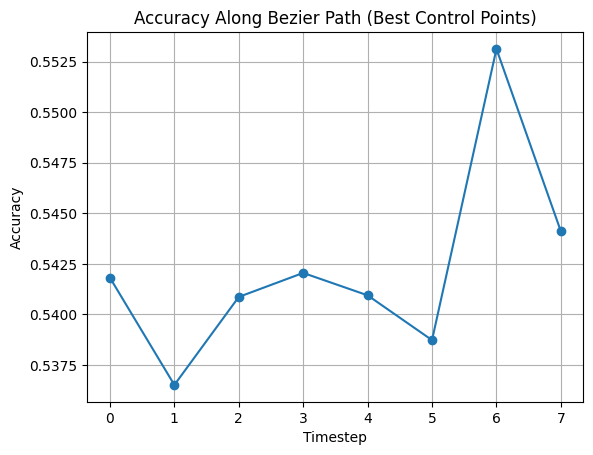

In [88]:
plt.plot(range(len(acc2)), acc2, marker='o')
plt.title("Accuracy Along Bezier Path (Best Control Points)")
plt.xlabel("Timestep")
plt.ylabel("Accuracy")
plt.grid()
plt.show()

In [110]:
torch.save(model3_params, "model3_params.pt")
torch.save(point2params, "point2params.pt")

In [33]:
loaded_model3_params = torch.load("model3_params.pt")
loaded_point2params = torch.load("point2params.pt")
loaded_model3_params

C:\Users\afyil\AppData\Local\Temp\ipykernel_13052\649023493.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model3_params = torch.load("model3_params.pt")
C:\Users\afyil

In [35]:
model3_params

tensor([ 0.0652, -0.0253,  0.0262,  ..., -0.0968, -0.3129, -0.3511],
       device='cuda:0')

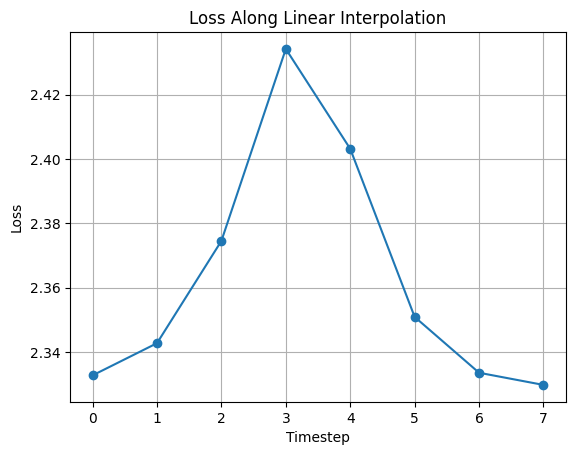

In [90]:
import torch
import numpy as np
import matplotlib.pyplot as plt



x_test = x_test.to(device)
y_test = y_test.to(device)

layer_sizes = [1024, 512, 256, 16]



# Doğrusal interpolasyon fonksiyonu
def linear_interpolation(t, w1, w2):
    return (1 - t) * w1 + t * w2




def evaluate_linear_interpolation_loss(w1, w2, X, y, criterion, layer_sizes, num_steps=8):
    losses = []
    acc = []
    for step in range(num_steps):
        t = step / (num_steps - 1)
        params = linear_interpolation(t, w1, w2)

        # Manuel yeniden kurma için layer_sizes (katman boyutları)
        #layer_sizes = [input_size, hidden_size, hidden_size1, output_size]    (girdi olarak verdim)
        
        # Manuel olarak ileri yayılımı gerçekleştir
        outputs = manual_model_forward(X, params, layer_sizes)
        predicted_classes = torch.argmax(outputs, dim=1)
        true_classes = torch.argmax(y, dim=1)
        loss = criterion(outputs, torch.argmax(y, dim=1))
        accuracy = (predicted_classes == true_classes).sum().item() / true_classes.size(0)
        acc.append(accuracy)
        losses.append(loss.item())
    return losses, acc



if __name__ == "__main__":


    x_train = torch.FloatTensor(x_train)
    y_train = torch.FloatTensor(y_train)

    #w1 = torch.randn(1025, requires_grad=False)  # 1024 ağırlık + 1 bias
    #w2 = torch.randn(1025, requires_grad=False)

    criterion = nn.CrossEntropyLoss()

    losses_lin2, acc_lin2 = evaluate_linear_interpolation_loss(model2_params, model3_params, x_test, y_test, criterion, layer_sizes)
    # Loss grafiği çizimi
    plt.plot(range(len(losses_lin2)), losses_lin2, marker='o')
    plt.title("Loss Along Linear Interpolation")
    plt.xlabel("Timestep")
    plt.ylabel("Loss")
    plt.grid()
    plt.show()


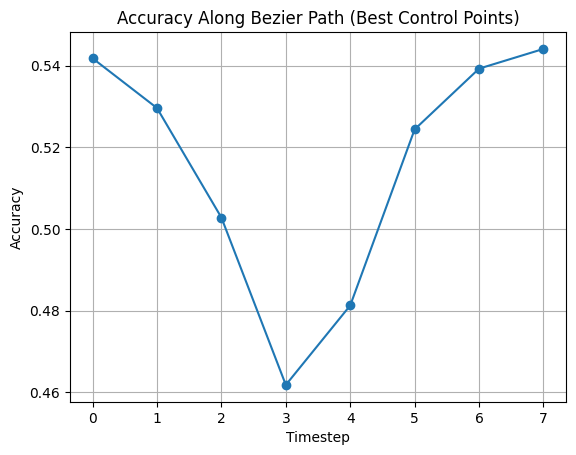

In [92]:
plt.plot(range(len(acc_lin2)), acc_lin2, marker='o')
plt.title("Accuracy Along Bezier Path (Best Control Points)")
plt.xlabel("Timestep")
plt.ylabel("Accuracy")
plt.grid()
plt.show()

In [70]:
x_test.device

device(type='cuda', index=0)

In [72]:
model1_params.device

device(type='cuda', index=0)

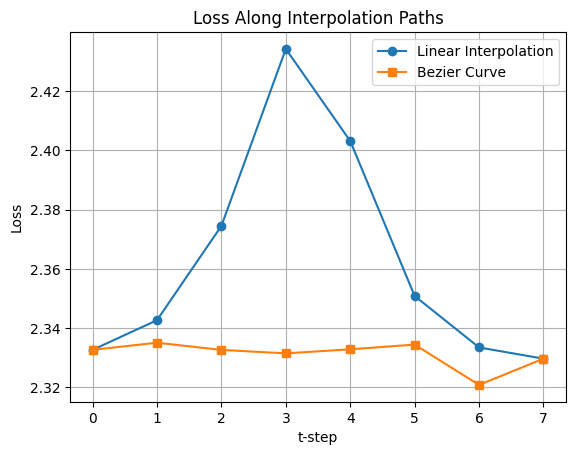

In [94]:
plt.plot(range(len(losses_lin2)), losses_lin2, marker='o', label='Linear Interpolation')
plt.plot(range(len(losses_bez2)), losses_bez2, marker='s', label='Bezier Curve')
plt.title("Loss Along Interpolation Paths")
plt.xlabel("t-step")
plt.ylabel("Loss")
plt.grid()
plt.legend()
plt.show()

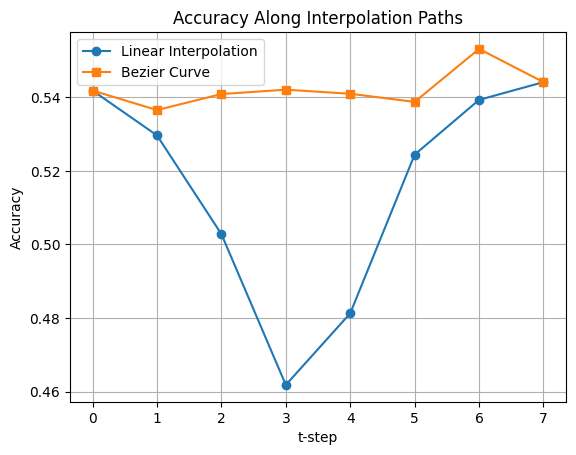

In [96]:
plt.plot(range(len(acc_lin2)), acc_lin2, marker='o', label='Linear Interpolation')
plt.plot(range(len(acc2)), acc2, marker='s', label='Bezier Curve')
plt.title("Accuracy Along Interpolation Paths")
plt.xlabel("t-step")
plt.ylabel("Accuracy")
plt.grid()
plt.legend()  # Açıklamayı eklemek için
plt.show()

#### ücüncü yol

Epoch [10/100], Loss: 18.7132
Epoch [20/100], Loss: 17.9307
Epoch [30/100], Loss: 17.4930
Epoch [40/100], Loss: 17.2366
Epoch [50/100], Loss: 17.0500
Epoch [60/100], Loss: 16.9063
Epoch [70/100], Loss: 16.8125
Epoch [80/100], Loss: 16.7323
Epoch [90/100], Loss: 16.6576
Epoch [100/100], Loss: 16.7136
en iyi kontrol noktaları:
[tensor([ 0.0253, -0.0568,  0.0476,  ..., -0.0166,  0.1292, -0.0517],
       device='cuda:0'), tensor([-0.7840, -2.4808, -1.2172,  ..., -1.2872, -0.0572, -2.1367],
       device='cuda:0'), tensor([-0.0223,  0.4835, -0.1391,  ..., -0.0939,  0.2498, -1.7451],
       device='cuda:0'), tensor([-1.1879,  0.4774, -1.6528,  ...,  0.5827,  1.4404,  0.9743],
       device='cuda:0'), tensor([ 0.0616, -0.0845,  0.0669,  ..., -0.1179, -0.0342,  0.1163],
       device='cuda:0')]
ilk kontrol noktaları:
[Parameter containing:
tensor([-0.7693, -2.6561, -1.1979,  ..., -1.2703, -0.1722, -2.0884],
       device='cuda:0', requires_grad=True), Parameter containing:
tensor([-0.1195,  0.

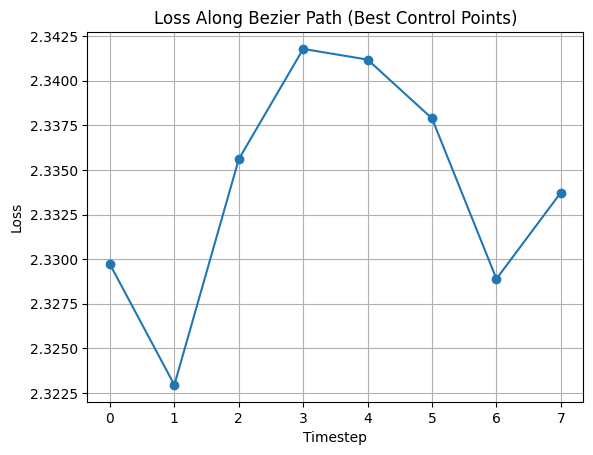

In [98]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import math
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset


class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, hidden_size1, output_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size1)
        self.relu = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size1, output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.softmax(x)
        return x


def train_model_with_shuffling(model, X, y, optimizer, criterion, epochs=500, batch_size=2048):
    dataset = TensorDataset(X, y)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    for epoch in range(epochs):
        for batch_X, batch_y in dataloader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, torch.argmax(batch_y, dim=1))
            loss.backward()
            optimizer.step()

    return model


def get_model_params(model):
    return torch.cat([p.data.flatten() for p in model.parameters()])


def manual_model_forward(X, params, layer_sizes):
    W1 = params[:layer_sizes[0] * layer_sizes[1]].reshape(layer_sizes[1], layer_sizes[0])
    b1 = params[layer_sizes[0] * layer_sizes[1]:layer_sizes[0] * layer_sizes[1] + layer_sizes[1]]
    
    W2_start = layer_sizes[0] * layer_sizes[1] + layer_sizes[1]
    W2 = params[W2_start:W2_start + layer_sizes[1] * layer_sizes[2]].reshape(layer_sizes[2], layer_sizes[1])
    b2_start = W2_start + layer_sizes[1] * layer_sizes[2]
    b2 = params[b2_start:b2_start + layer_sizes[2]]
    
    W3_start = b2_start + layer_sizes[2]
    W3 = params[W3_start:W3_start + layer_sizes[2] * layer_sizes[3]].reshape(layer_sizes[3], layer_sizes[2])
    b3_start = W3_start + layer_sizes[2] * layer_sizes[3]
    b3 = params[b3_start:]


    W1 = W1.to(device)
    W2 = W2.to(device)
    W3 = W3.to(device)
    b1 = b1.to(device)
    b2 = b2.to(device)
    b3 = b3.to(device)

    
    x = torch.relu(X @ W1.T + b1)
    x = torch.relu(x @ W2.T + b2)
    x = torch.softmax(x @ W3.T + b3, dim=1)
    return x


def compute_bezier_point(t, control_points):
    n = len(control_points) - 1
    point = torch.zeros_like(control_points[0])

    for i in range(n + 1):
        coef = torch.tensor(math.comb(n, i) * (t ** i) * ((1 - t) ** (n - i)), device=control_points[0].device)
        point += coef * control_points[i]

    return point


def optimize_path(model3_params, model4_params, criterion, X, y, layer_sizes, num_steps=8, num_iterations=100):
    param_size = len(model3_params)

    control_points = [
        model3_params.clone().detach().to(device).requires_grad_(False),
        torch.randn(param_size, device=device, requires_grad=True),
        torch.randn(param_size, device=device, requires_grad=True),
        torch.randn(param_size, device=device, requires_grad=True),
        model4_params.clone().detach().to(device).requires_grad_(False)
    ]

    middle_points111 = [torch.nn.Parameter(p.clone()) for p in control_points[1:-1]]
    optimizer = optim.Adam(control_points[1:-1], lr=0.01)
    best_loss = float('inf')
    best_control_points = None

    for iteration in range(num_iterations):
        total_path_loss = 0

        for step in range(num_steps):
            t = step / (num_steps - 1)
            params = compute_bezier_point(t, control_points)
            outputs = manual_model_forward(X, params, layer_sizes)
            loss = criterion(outputs, torch.argmax(y, dim=1))
            total_path_loss += loss

        optimizer.zero_grad()
        total_path_loss.backward()
        optimizer.step()

        # Ara sıra kaybı yazdır
        if (iteration + 1) % 10 == 0:
            print(f"Epoch [{iteration+1}/{num_iterations}], Loss: {total_path_loss.item():.4f}")

        if total_path_loss.item() < best_loss:
            best_loss = total_path_loss.item()
            best_control_points = [p.clone().detach() for p in control_points]

    return best_control_points, best_loss, middle_points111


def evaluate_best_path_loss(best_control_points, X, y, criterion, layer_sizes, num_steps=8):
    losses = []
    acc = []
    for step in range(num_steps):
        t = step / (num_steps - 1)
        params = compute_bezier_point(t, best_control_points)
      
        if t == (3/7):
            point3params = params  

        # Manuel yeniden kurma için layer_sizes (katman boyutları)
        #layer_sizes = [input_size, hidden_size, hidden_size1, output_size]    (girdi olarak verdim)
        
        # Manuel olarak ileri yayılımı gerçekleştir
        outputs = manual_model_forward(X, params, layer_sizes)
        predicted_classes = torch.argmax(outputs, dim=1)
        true_classes = torch.argmax(y, dim=1)
        loss = criterion(outputs, torch.argmax(y, dim=1))
        accuracy = (predicted_classes == true_classes).sum().item() / true_classes.size(0)
        acc.append(accuracy)
        losses.append(loss.item())
    return losses, point3params, acc


def find_path_between_minima(x_train, y_train, x_test, y_test, model3_params):
    global device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    if not isinstance(x_train, torch.Tensor):
        x_train = torch.FloatTensor(x_train).to(device)
    if not isinstance(y_train, torch.Tensor):
        y_train = torch.FloatTensor(y_train).to(device)
    if not isinstance(x_test, torch.Tensor):
        x_test = torch.FloatTensor(x_test).to(device)
    if not isinstance(y_test, torch.Tensor):
        y_test = torch.FloatTensor(y_test).to(device)


    x_train = x_train.to(device)
    y_train = y_train.to(device)
    x_test = x_test.to(device)
    y_test = y_test.to(device)
    

    input_size = 1024
    hidden_size = 512
    hidden_size1 = 256
    output_size = 16
    layer_sizes = [input_size, hidden_size, hidden_size1, output_size]

    model4 = SimpleNN(input_size, hidden_size, hidden_size1, output_size).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer3 = optim.Adam(model4.parameters(), lr=0.01)

    model4 = train_model_with_shuffling(model4, x_train, y_train, optimizer3, criterion)

    model4_params = get_model_params(model4)

    best_control_points, best_loss, middle_points111 = optimize_path(
        model3_params,
        model4_params,
        criterion,
        x_train,
        y_train,
        layer_sizes
    )

    losses_bez, point3params, acc = evaluate_best_path_loss(best_control_points, x_test, y_test, criterion, layer_sizes)

    return best_control_points, best_loss, losses_bez, middle_points111, model4_params, point3params, acc


if __name__ == "__main__":
    best_control_points, best_loss, losses_bez3, middle_points111, model4_params, point3params, acc3 = find_path_between_minima(x_train, y_train, x_test, y_test, model3_params)

    print("en iyi kontrol noktaları:")
    print(best_control_points)
    print("ilk kontrol noktaları:")
    print(middle_points111)
    
    plt.plot(range(len(losses_bez3)), losses_bez3, marker='o')
    plt.title("Loss Along Bezier Path (Best Control Points)")
    plt.xlabel("Timestep")
    plt.ylabel("Loss")
    plt.grid()
    plt.show()


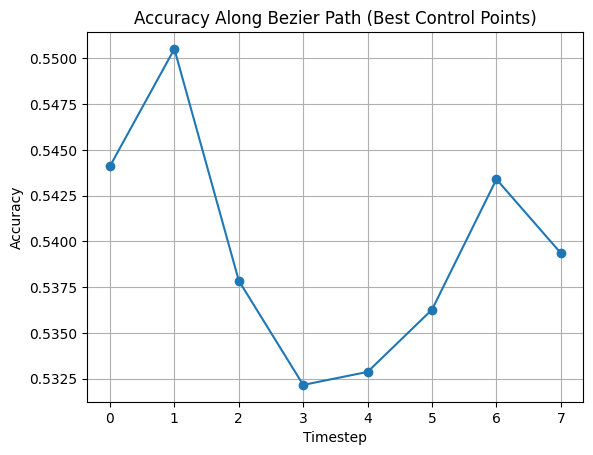

In [100]:
plt.plot(range(len(acc3)), acc3, marker='o')
plt.title("Accuracy Along Bezier Path (Best Control Points)")
plt.xlabel("Timestep")
plt.ylabel("Accuracy")
plt.grid()
plt.show()

In [112]:
torch.save(model4_params, "model4_params.pt")
torch.save(point3params, "point3params.pt")

In [84]:
loaded_model4_params = torch.load("model4_params.pt")
loaded_point3params = torch.load("point3params.pt")
loaded_model4_params

C:\Users\afyil\AppData\Local\Temp\ipykernel_15248\3385383944.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model4_params = torch.load("model4_params.pt")
C:\Use

tensor([ 0.0784, -0.0484,  0.0748,  ..., -0.3402, -0.0119, -0.1732],
       device='cuda:0')

In [85]:
model4_params

tensor([ 0.0784, -0.0484,  0.0748,  ..., -0.3402, -0.0119, -0.1732],
       device='cuda:0')

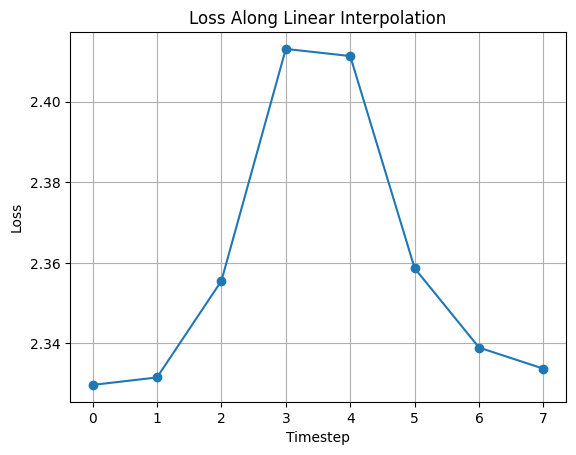

In [102]:
import torch
import numpy as np
import matplotlib.pyplot as plt



x_test = x_test.to(device)
y_test = y_test.to(device)

layer_sizes = [1024, 512, 256, 16]



# Doğrusal interpolasyon fonksiyonu
def linear_interpolation(t, w1, w2):
    return (1 - t) * w1 + t * w2




def evaluate_linear_interpolation_loss(w1, w2, X, y, criterion, layer_sizes, num_steps=8):
    losses = []
    acc = []
    for step in range(num_steps):
        t = step / (num_steps - 1)
        params = linear_interpolation(t, w1, w2)

        # Manuel yeniden kurma için layer_sizes (katman boyutları)
        #layer_sizes = [input_size, hidden_size, hidden_size1, output_size]    (girdi olarak verdim)
        
        # Manuel olarak ileri yayılımı gerçekleştir
        outputs = manual_model_forward(X, params, layer_sizes)
        predicted_classes = torch.argmax(outputs, dim=1)
        true_classes = torch.argmax(y, dim=1)
        loss = criterion(outputs, torch.argmax(y, dim=1))
        accuracy = (predicted_classes == true_classes).sum().item() / true_classes.size(0)
        acc.append(accuracy)
        losses.append(loss.item())
    return losses, acc



if __name__ == "__main__":


    x_train = torch.FloatTensor(x_train)
    y_train = torch.FloatTensor(y_train)

    #w1 = torch.randn(1025, requires_grad=False)  # 1024 ağırlık + 1 bias
    #w2 = torch.randn(1025, requires_grad=False)

    criterion = nn.CrossEntropyLoss()

    losses_lin3, acc_lin3 = evaluate_linear_interpolation_loss(model3_params, model4_params, x_test, y_test, criterion, layer_sizes)
    # Loss grafiği çizimi
    plt.plot(range(len(losses_lin3)), losses_lin3, marker='o')
    plt.title("Loss Along Linear Interpolation")
    plt.xlabel("Timestep")
    plt.ylabel("Loss")
    plt.grid()
    plt.show()


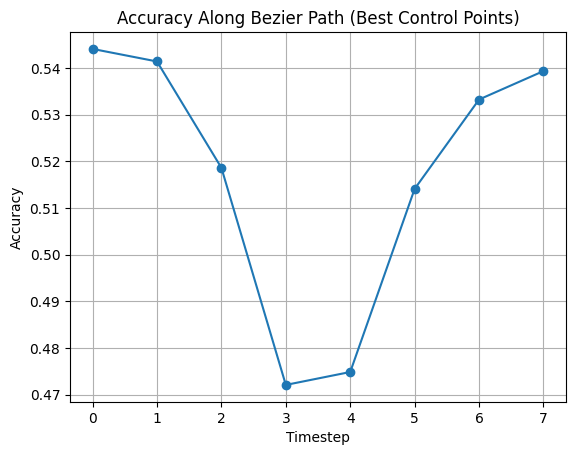

In [104]:
plt.plot(range(len(acc_lin3)), acc_lin3, marker='o')
plt.title("Accuracy Along Bezier Path (Best Control Points)")
plt.xlabel("Timestep")
plt.ylabel("Accuracy")
plt.grid()
plt.show()

In [70]:
x_test.device

device(type='cuda', index=0)

In [72]:
model1_params.device

device(type='cuda', index=0)

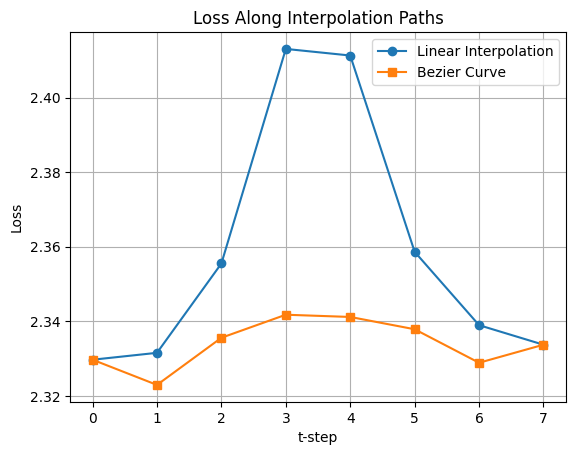

In [106]:
plt.plot(range(len(losses_lin3)), losses_lin3, marker='o', label='Linear Interpolation')
plt.plot(range(len(losses_bez3)), losses_bez3, marker='s', label='Bezier Curve')
plt.title("Loss Along Interpolation Paths")
plt.xlabel("t-step")
plt.ylabel("Loss")
plt.grid()
plt.legend()  # Açıklamayı eklemek için
plt.show()

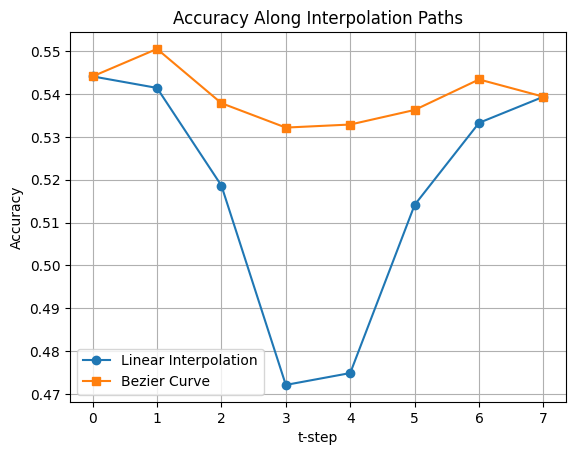

In [108]:
plt.plot(range(len(acc_lin3)), acc_lin3, marker='o', label='Linear Interpolation')
plt.plot(range(len(acc3)), acc3, marker='s', label='Bezier Curve')
plt.title("Accuracy Along Interpolation Paths")
plt.xlabel("t-step")
plt.ylabel("Accuracy")
plt.grid()
plt.legend()  # Açıklamayı eklemek için
plt.show()

#### dördüncü yol

Epoch [10/100], Loss: 18.5539
Epoch [20/100], Loss: 17.8087
Epoch [30/100], Loss: 17.4165
Epoch [40/100], Loss: 17.1732
Epoch [50/100], Loss: 17.0081
Epoch [60/100], Loss: 16.9005
Epoch [70/100], Loss: 16.7904
Epoch [80/100], Loss: 16.6888
Epoch [90/100], Loss: 16.6076
Epoch [100/100], Loss: 16.6315
en iyi kontrol noktaları:
[tensor([ 0.0616, -0.0845,  0.0669,  ..., -0.1179, -0.0342,  0.1163],
       device='cuda:0'), tensor([-0.7221,  0.1968, -1.8854,  ...,  0.1127,  1.3812, -0.0443],
       device='cuda:0'), tensor([-0.3385, -0.7639,  1.5205,  ..., -0.2507, -0.6611, -0.2640],
       device='cuda:0'), tensor([-0.3139, -1.6242, -0.2511,  ...,  0.2494,  0.2617,  1.2515],
       device='cuda:0'), tensor([ 1.3402,  0.1726, -0.4200,  ..., -0.1675, -0.1029, -0.0077],
       device='cuda:0')]
ilk kontrol noktaları:
[Parameter containing:
tensor([-0.6095,  0.1225, -1.8573,  ..., -0.0674,  1.3501, -0.0648],
       device='cuda:0', requires_grad=True), Parameter containing:
tensor([-0.2245, -0.

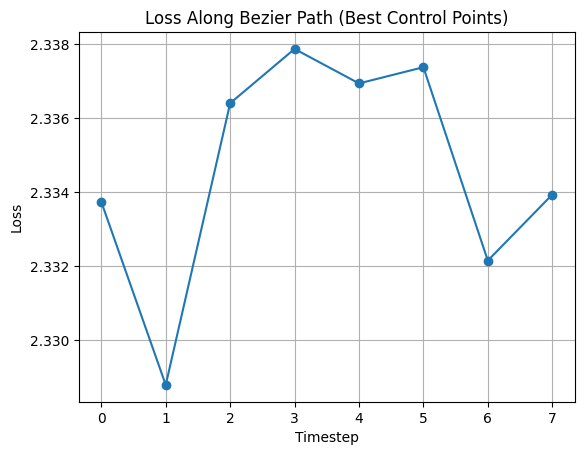

In [136]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import math
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset


class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, hidden_size1, output_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size1)
        self.relu = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size1, output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.softmax(x)
        return x


def train_model_with_shuffling(model, X, y, optimizer, criterion, epochs=500, batch_size=2048):
    dataset = TensorDataset(X, y)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    for epoch in range(epochs):
        for batch_X, batch_y in dataloader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, torch.argmax(batch_y, dim=1))
            loss.backward()
            optimizer.step()

    return model


def get_model_params(model):
    return torch.cat([p.data.flatten() for p in model.parameters()])


def manual_model_forward(X, params, layer_sizes):
    W1 = params[:layer_sizes[0] * layer_sizes[1]].reshape(layer_sizes[1], layer_sizes[0])
    b1 = params[layer_sizes[0] * layer_sizes[1]:layer_sizes[0] * layer_sizes[1] + layer_sizes[1]]
    
    W2_start = layer_sizes[0] * layer_sizes[1] + layer_sizes[1]
    W2 = params[W2_start:W2_start + layer_sizes[1] * layer_sizes[2]].reshape(layer_sizes[2], layer_sizes[1])
    b2_start = W2_start + layer_sizes[1] * layer_sizes[2]
    b2 = params[b2_start:b2_start + layer_sizes[2]]
    
    W3_start = b2_start + layer_sizes[2]
    W3 = params[W3_start:W3_start + layer_sizes[2] * layer_sizes[3]].reshape(layer_sizes[3], layer_sizes[2])
    b3_start = W3_start + layer_sizes[2] * layer_sizes[3]
    b3 = params[b3_start:]


    W1 = W1.to(device)
    W2 = W2.to(device)
    W3 = W3.to(device)
    b1 = b1.to(device)
    b2 = b2.to(device)
    b3 = b3.to(device)

    
    x = torch.relu(X @ W1.T + b1)
    x = torch.relu(x @ W2.T + b2)
    x = torch.softmax(x @ W3.T + b3, dim=1)
    return x


def compute_bezier_point(t, control_points):
    n = len(control_points) - 1
    point = torch.zeros_like(control_points[0])

    for i in range(n + 1):
        coef = torch.tensor(math.comb(n, i) * (t ** i) * ((1 - t) ** (n - i)), device=control_points[0].device)
        point += coef * control_points[i]

    return point


def optimize_path(model4_params, model5_params, criterion, X, y, layer_sizes, num_steps=8, num_iterations=100):
    param_size = len(model4_params)

    control_points = [
        model4_params.clone().detach().to(device).requires_grad_(False),
        torch.randn(param_size, device=device, requires_grad=True),
        torch.randn(param_size, device=device, requires_grad=True),
        torch.randn(param_size, device=device, requires_grad=True),
        model5_params.clone().detach().to(device).requires_grad_(False)
    ]

    middle_points111 = [torch.nn.Parameter(p.clone()) for p in control_points[1:-1]]
    optimizer = optim.Adam(control_points[1:-1], lr=0.01)
    best_loss = float('inf')
    best_control_points = None

    for iteration in range(num_iterations):
        total_path_loss = 0

        for step in range(num_steps):
            t = step / (num_steps - 1)
            params = compute_bezier_point(t, control_points)
            outputs = manual_model_forward(X, params, layer_sizes)
            loss = criterion(outputs, torch.argmax(y, dim=1))
            total_path_loss += loss

        optimizer.zero_grad()
        total_path_loss.backward()
        optimizer.step()

        # Ara sıra kaybı yazdır
        if (iteration + 1) % 10 == 0:
            print(f"Epoch [{iteration+1}/{num_iterations}], Loss: {total_path_loss.item():.4f}")

        if total_path_loss.item() < best_loss:
            best_loss = total_path_loss.item()
            best_control_points = [p.clone().detach() for p in control_points]

    return best_control_points, best_loss, middle_points111


def evaluate_best_path_loss(best_control_points, X, y, criterion, layer_sizes, num_steps=8):
    losses = []
    acc = []
    for step in range(num_steps):
        t = step / (num_steps - 1)
        params = compute_bezier_point(t, best_control_points)
      
        if t == (3/7):
            point4params = params  

        # Manuel yeniden kurma için layer_sizes (katman boyutları)
        #layer_sizes = [input_size, hidden_size, hidden_size1, output_size]    (girdi olarak verdim)
        
        # Manuel olarak ileri yayılımı gerçekleştir
        outputs = manual_model_forward(X, params, layer_sizes)
        predicted_classes = torch.argmax(outputs, dim=1)
        true_classes = torch.argmax(y, dim=1)
        loss = criterion(outputs, torch.argmax(y, dim=1))
        accuracy = (predicted_classes == true_classes).sum().item() / true_classes.size(0)
        acc.append(accuracy)
        losses.append(loss.item())
    return losses, point4params, acc


def find_path_between_minima(x_train, y_train, x_test, y_test, model4_params):
    global device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    if not isinstance(x_train, torch.Tensor):
        x_train = torch.FloatTensor(x_train).to(device)
    if not isinstance(y_train, torch.Tensor):
        y_train = torch.FloatTensor(y_train).to(device)
    if not isinstance(x_test, torch.Tensor):
        x_test = torch.FloatTensor(x_test).to(device)
    if not isinstance(y_test, torch.Tensor):
        y_test = torch.FloatTensor(y_test).to(device)


    x_train = x_train.to(device)
    y_train = y_train.to(device)
    x_test = x_test.to(device)
    y_test = y_test.to(device)
    

    input_size = 1024
    hidden_size = 512
    hidden_size1 = 256
    output_size = 16
    layer_sizes = [input_size, hidden_size, hidden_size1, output_size]

    model5 = SimpleNN(input_size, hidden_size, hidden_size1, output_size).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer3 = optim.Adam(model5.parameters(), lr=0.01)

    model5 = train_model_with_shuffling(model5, x_train, y_train, optimizer3, criterion)

    model5_params = get_model_params(model5)

    best_control_points, best_loss, middle_points111 = optimize_path(
        model4_params,
        model5_params,
        criterion,
        x_train,
        y_train,
        layer_sizes
    )

    losses_bez, point4params, acc = evaluate_best_path_loss(best_control_points, x_test, y_test, criterion, layer_sizes)

    return best_control_points, best_loss, losses_bez, middle_points111, model5_params, point4params, acc


if __name__ == "__main__":
    best_control_points, best_loss, losses_bez4, middle_points111, model5_params, point4params, acc4 = find_path_between_minima(x_train, y_train, x_test, y_test, model4_params)

    print("en iyi kontrol noktaları:")
    print(best_control_points)
    print("ilk kontrol noktaları:")
    print(middle_points111)
    
    plt.plot(range(len(losses_bez4)), losses_bez4, marker='o')
    plt.title("Loss Along Bezier Path (Best Control Points)")
    plt.xlabel("Timestep")
    plt.ylabel("Loss")
    plt.grid()
    plt.show()


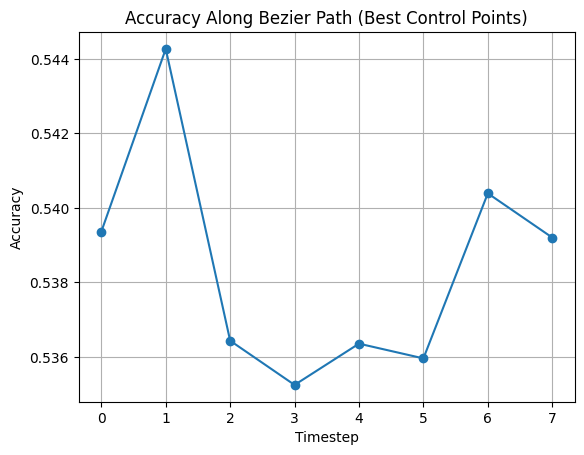

In [139]:
plt.plot(range(len(acc4)), acc4, marker='o')
plt.title("Accuracy Along Bezier Path (Best Control Points)")
plt.xlabel("Timestep")
plt.ylabel("Accuracy")
plt.grid()
plt.show()

In [149]:
torch.save(model5_params, "model5_params.pt")
torch.save(point4params, "point4params.pt")

In [99]:
loaded_model5_params = torch.load("model5_params.pt")
loaded_point4params = torch.load("point4params.pt")
loaded_model5_params

C:\Users\afyil\AppData\Local\Temp\ipykernel_15248\3352819220.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model5_params = torch.load("model5_params.pt")
C:\Use

tensor([ 0.0767,  0.0753,  0.0896,  ..., -0.1976, -0.0115,  0.0111],
       device='cuda:0')

In [100]:
model5_params

tensor([ 0.0767,  0.0753,  0.0896,  ..., -0.1976, -0.0115,  0.0111],
       device='cuda:0')

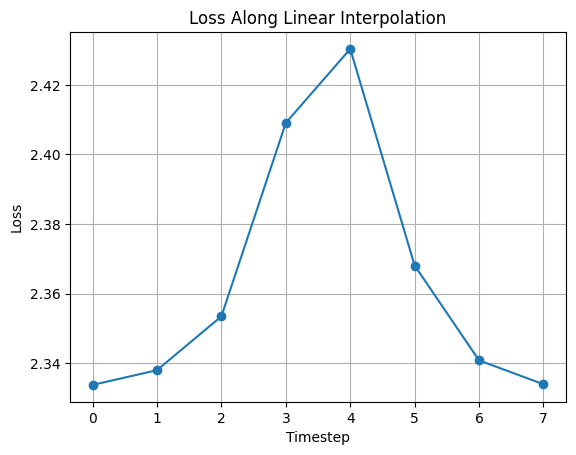

In [141]:
import torch
import numpy as np
import matplotlib.pyplot as plt



x_test = x_test.to(device)
y_test = y_test.to(device)

layer_sizes = [1024, 512, 256, 16]



# Doğrusal interpolasyon fonksiyonu
def linear_interpolation(t, w1, w2):
    return (1 - t) * w1 + t * w2




def evaluate_linear_interpolation_loss(w1, w2, X, y, criterion, layer_sizes, num_steps=8):
    losses = []
    acc = []
    for step in range(num_steps):
        t = step / (num_steps - 1)
        params = linear_interpolation(t, w1, w2)

        # Manuel yeniden kurma için layer_sizes (katman boyutları)
        #layer_sizes = [input_size, hidden_size, hidden_size1, output_size]    (girdi olarak verdim)
        
        # Manuel olarak ileri yayılımı gerçekleştir
        outputs = manual_model_forward(X, params, layer_sizes)
        predicted_classes = torch.argmax(outputs, dim=1)
        true_classes = torch.argmax(y, dim=1)
        loss = criterion(outputs, torch.argmax(y, dim=1))
        accuracy = (predicted_classes == true_classes).sum().item() / true_classes.size(0)
        acc.append(accuracy)
        losses.append(loss.item())
    return losses, acc



if __name__ == "__main__":


    x_train = torch.FloatTensor(x_train)
    y_train = torch.FloatTensor(y_train)

    #w1 = torch.randn(1025, requires_grad=False)  # 1024 ağırlık + 1 bias
    #w2 = torch.randn(1025, requires_grad=False)

    criterion = nn.CrossEntropyLoss()

    losses_lin4, acc_lin4 = evaluate_linear_interpolation_loss(model4_params, model5_params, x_test, y_test, criterion, layer_sizes)
    # Loss grafiği çizimi
    plt.plot(range(len(losses_lin4)), losses_lin4, marker='o')
    plt.title("Loss Along Linear Interpolation")
    plt.xlabel("Timestep")
    plt.ylabel("Loss")
    plt.grid()
    plt.show()


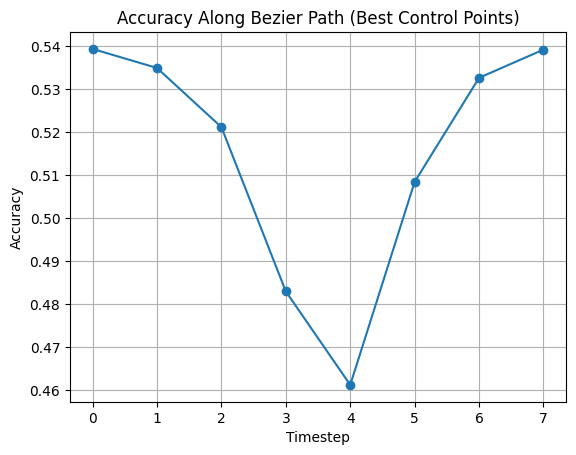

In [143]:
plt.plot(range(len(acc_lin4)), acc_lin4, marker='o')
plt.title("Accuracy Along Bezier Path (Best Control Points)")
plt.xlabel("Timestep")
plt.ylabel("Accuracy")
plt.grid()
plt.show()

In [70]:
x_test.device

device(type='cuda', index=0)

In [72]:
model1_params.device

device(type='cuda', index=0)

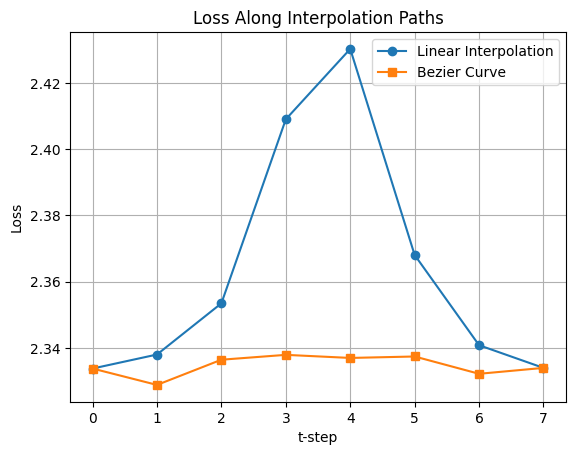

In [145]:
plt.plot(range(len(losses_lin4)), losses_lin4, marker='o', label='Linear Interpolation')
plt.plot(range(len(losses_bez4)), losses_bez4, marker='s', label='Bezier Curve')
plt.title("Loss Along Interpolation Paths")
plt.xlabel("t-step")
plt.ylabel("Loss")
plt.grid()
plt.legend()  # Açıklamayı eklemek için
plt.show()

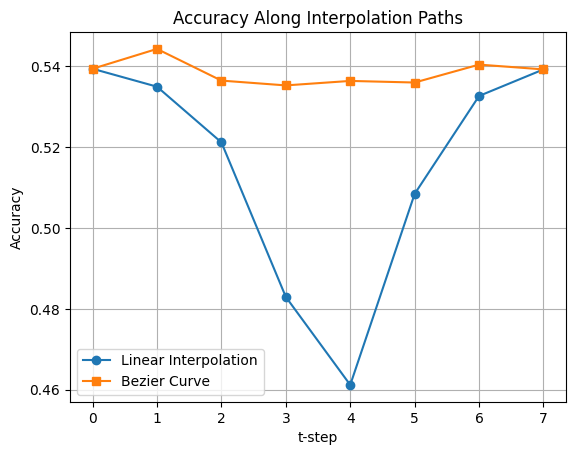

In [147]:
plt.plot(range(len(acc_lin4)), acc_lin4, marker='o', label='Linear Interpolation')
plt.plot(range(len(acc4)), acc4, marker='s', label='Bezier Curve')
plt.title("Accuracy Along Interpolation Paths")
plt.xlabel("t-step")
plt.ylabel("Accuracy")
plt.grid()
plt.legend()  # Açıklamayı eklemek için
plt.show()

### 5 minimum birleşimi

In [151]:
combined_bez_loss = losses_bez1 + losses_bez2[1:] + losses_bez3[1:] + losses_bez4[1:]
combined_lin_loss = losses_lin1 + losses_lin2[1:] + losses_lin3[1:] + losses_lin4[1:]
combined_bez_acc = acc1 + acc2[1:] + acc3[1:] + acc4[1:]
combined_lin_acc = acc_lin1 + acc_lin2[1:] + acc_lin3[1:] + acc_lin4[1:]

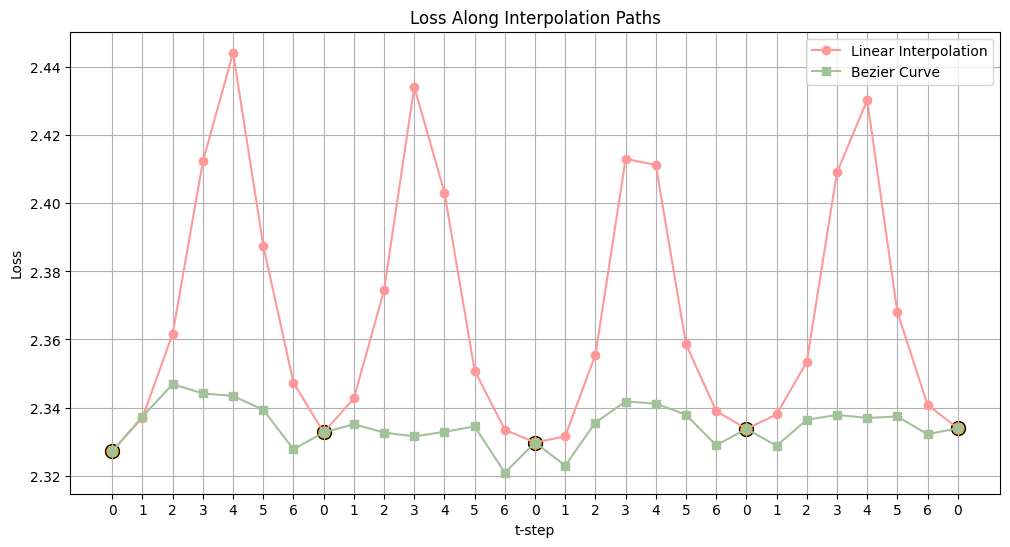

In [230]:
# Örnek: x=0, x=5 ve x=10'daki değerlere vurgu ekleyelim.
critical_points = [0, 7, 14, 21, 28]

# Grafik çizimi
plt.figure(figsize=(12, 6))

# Linear Interpolation (Mavi çizgi)
plt.plot(x, combined_lin_loss, marker='o', label='Linear Interpolation', color='#FF9999')

# Bezier Curve (Turuncu çizgi)
plt.plot(x, combined_bez_loss, marker='s', label='Bezier Curve', color='#A3C29B')


# Kritik noktalar için döngü ile vurgu ekleme
for point in critical_points:
    plt.scatter(point, combined_bez_loss[point], color='orange', s=100, edgecolors='black')

# X ekseni etiketleri
x_labels = [str(label % 7) for label in x]
plt.xticks(x, x_labels)

# Başlık ve etiketler
plt.title('Loss Along Interpolation Paths')
plt.xlabel('t-step')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()


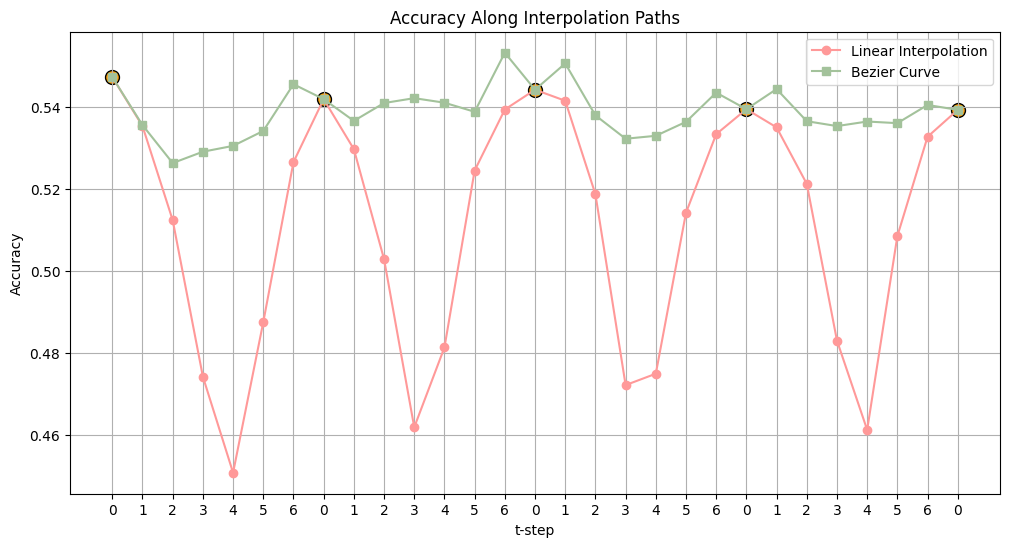

In [234]:
# Örnek: x=0, x=5 ve x=10'daki değerlere vurgu ekleyelim.
critical_points = [0, 7, 14, 21, 28]

# Grafik çizimi
plt.figure(figsize=(12, 6))

# Linear Interpolation (Mavi çizgi)
plt.plot(x, combined_lin_acc, marker='o', label='Linear Interpolation', color='#FF9999')

# Bezier Curve (Turuncu çizgi)
plt.plot(x, combined_bez_acc, marker='s', label='Bezier Curve', color='#A3C29B')


# Kritik noktalar için döngü ile vurgu ekleme
for point in critical_points:
    plt.scatter(point, combined_bez_acc[point], color='orange', s=100, edgecolors='black')

# X ekseni etiketleri
x_labels = [str(label % 7) for label in x]
plt.xticks(x, x_labels)

# Başlık ve etiketler
plt.title('Accuracy Along Interpolation Paths')
plt.xlabel('t-step')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()
plt.show()


### .